### Semi-global-Matching (SGM) on GPU.

#### 1. Required packages

In [ ]:
! pip install pycuda
! pip install tqdm

In [37]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import scipy.signal as signal


import pycuda
import pycuda.driver as drv
from pycuda import gpuarray
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.driver as cuda

#### 2. Loading stereo images

In [3]:
print("Loading the stereo images")
img_left = cv2.imread(("kitti_left.png"), 0)
img_right = cv2.imread(("kitti_right.png"), 0)

# Bilateral Filter: Gaussian + edge preservation
img_left = cv2.bilateralFilter(img_left, 9, 8, 15)
img_right = cv2.bilateralFilter(img_right, 9, 8, 15)

#### 3. Initial Cost Volume Calculation: Census + Hanmming Distance

In [5]:
class Parameters:
  '''
  Define the parameters:
  max_disparity: estimated maximum disparity of stereo images
  P1: penatly on neighboring pixels
  P2: penalty on distant pixels
  csize: windows size of census transform
  '''
  def __init__(self, max_disparity = 80, P1 = 10, P2 = 120, csize=(5,5)):
    self.max_disparity = max_disparity
    self.P1 = P1
    self.P2 = P2
    self.csize = csize

def compute_cost(img_left, img_right, parameters):
    '''
    first step of the sgm algorithm, matching cost based on census transform and hamming distance.
    :param left: left image.
    :param right: right image.
    :param parameters: structure containing parameters of the algorithm.
    :return: H x W x D array with the matching costs. => cost volume
    '''
    assert img_left.shape[0] == img_right.shape[0] and img_left.shape[1] == img_right.shape[1], 'left & right must have the same shape.'
    assert parameters.max_disparity > 0, 'maximum disparity must be greater than 0.'
    height = img_left.shape[0]
    width = img_left.shape[1]
    cheight = parameters.csize[0]
    cwidth = parameters.csize[1]
    # didint consider the image border
    y_offset = int(cheight / 2)
    x_offset = int(cwidth / 2)
    disparity = parameters.max_disparity   
    
    # --------- Faster Census Transform and cost volume calculation ---------- #
    # 
    image_left_no_border = img_left[y_offset : height - y_offset, x_offset : width - x_offset]
    image_right_no_border = img_right[y_offset : height - y_offset, x_offset : width - x_offset]


    left_census_values = np.zeros(shape=(height - 2*y_offset, width - 2*x_offset), dtype = np.uint64)
    right_census_values = np.zeros(shape=(height - 2*y_offset, width - 2*x_offset), dtype = np.uint64)

    compar_index = [(u,v) for u in range(cheight) for v in range(cwidth) if not u == x_offset == v]
    
    for u, v in compar_index:

      left_census_values = (left_census_values << 1) | (img_left[u:u + height - 2*y_offset, v:v + width - 2*x_offset] >= image_left_no_border)
      right_census_values = (right_census_values << 1) | (img_right[u:u + height - 2*y_offset, v:v + width - 2*x_offset] >= image_right_no_border)

    left_census_values = np.pad(left_census_values,x_offset,'reflect')
    right_census_values = np.pad(right_census_values,x_offset,'reflect')

    left_img_census = np.uint8(left_census_values)
    right_img_census = np.uint8(right_census_values)

    #cv2.imwrite('left_census_img.png', left_img_census)
    #cv2.imwrite('right_census_img.png', right_img_census) 

    # --------------------- Cost Volume Calculation: bitewise calculation hanmming distance --------------------------------- #
    left_cost_volume = np.zeros(shape = (height, width, disparity), dtype = np.uint32)
    right_cost_volume = np.zeros(shape = (height, width, disparity), dtype = np.uint32)
    # Storing the census after correcting disparity
    lcensus_dis = np.zeros(shape = (height, width), dtype = np.int64)
    rcensus_dis = np.zeros(shape = (height, width), dtype = np.int64)

    #### Can also be paralleled on GPU
    mask_sky_black_region_left = img_left == 0
    mask_sky_black_region_right = img_right == 0

    for d in range(0, disparity):

      rcensus_dis[:,(x_offset + d):(width - x_offset)] = right_census_values[:, x_offset:(width - d - x_offset)]
      # compare the similarity of corresponding pixels
      # left cost volume
      left_xor = np.bitwise_xor(np.int64(left_census_values), rcensus_dis)  # ^, exclusive OR
      left_distance = np.zeros(shape = (height, width), dtype = np.uint32) 
         
      mask = left_xor != 0
      left_distance[mask] = left_xor[mask]
      left_distance[mask] = (left_distance[mask] & 0x55555555) + (left_distance[mask] >>  1 & 0x55555555); 
      left_distance[mask] = (left_distance[mask] & 0x33333333) + (left_distance[mask] >>  2 & 0x33333333); 
      left_distance[mask] = (left_distance[mask] & 0x0F0F0F0F) + (left_distance[mask] >>  4 & 0x0F0F0F0F); 
      left_distance[mask] = (left_distance[mask] & 0x00FF00FF) + (left_distance[mask] >>  8 & 0x00FF00FF); 
      left_distance[mask] = (left_distance[mask] & 0x0000FFFF) + (left_distance[mask] >> 16 & 0x0000FFFF); 
      
      left_cost_volume[:,:,d] = left_distance

      # right cost volume
      lcensus_dis[:, x_offset:(width - d - x_offset)] = left_census_values[:, (x_offset + d):(width - x_offset)]
      right_xor = np.bitwise_xor(np.int64(right_census_values), lcensus_dis)
      right_distance = np.zeros(shape=(height, width), dtype=np.uint32)
      
      mask_right = right_xor != 0

      right_distance[mask_right] = right_xor[mask_right]
      right_distance[mask_right] = (right_distance[mask_right] & 0x55555555) + (right_distance[mask_right] >>  1 & 0x55555555); 
      right_distance[mask_right] = (right_distance[mask_right] & 0x33333333) + (right_distance[mask_right] >>  2 & 0x33333333); 
      right_distance[mask_right] = (right_distance[mask_right] & 0x0F0F0F0F) + (right_distance[mask_right] >>  4 & 0x0F0F0F0F); 
      right_distance[mask_right] = (right_distance[mask_right] & 0x00FF00FF) + (right_distance[mask_right] >>  8 & 0x00FF00FF); 
      right_distance[mask_right] = (right_distance[mask_right] & 0x0000FFFF) + (right_distance[mask_right] >> 16 & 0x0000FFFF); 

      right_cost_volume[:,:,d] = right_distance

    return left_cost_volume, right_cost_volume



In [15]:
# define the parameters and calculate initial cost volume
# max_disparity = 80 for kitti
parameters = Parameters(max_disparity=80, P1=10, P2=120, csize=(5,5))
print('\n Starting cost computation based on Census Transform and Hamming distance...')
left_cost_volume, right_cost_volume = compute_cost(img_left, img_right, parameters)
print('\n Initial Cost volume Calculation...Done')


 Starting cost computation based on Census Transform and Hamming distance...

 Initial Cost volume Calculation...Done


#### 4. Cost aggregation: Parallization on GPU

##### 4.1 PyCUDA Kernel Function that parallizes cost aggregation.
  
1.   First kernel function is used to parallize 4 horizontal and vertical directions  
2.   Second kernel function is used to parallize 4 diagonal directions
3.   This parallization was used to process my personal high-resolution stereo images(not KITTI) with long baseline and very large disparty, that's why I process 4 + 4  directions individually with the consideration of GPU memory allocation and release.


In [18]:
cost_aggre_kernel = SourceModule("""

__global__ void cost_aggregate(unsigned int * cost_volume, unsigned int * out_cost_volume, 
unsigned int volume_h, unsigned int volume_w, unsigned int volume_d, unsigned int para_P1, unsigned int para_P2)
{
  // height: H, width: W, disparity: D: threadIdx.x
  // Parallel W and Parallel Disparity

  const int h = volume_h;
  const int w = volume_w;
  const int dmax = volume_d;

  const int P1 = para_P1;
  const int P2 = para_P2;

  const int index_volume = h * w * dmax;

  const int d = threadIdx.x;
  //const int d = threadIdx.x; + d_min;
  const int dir = blockIdx.x;

  int dx = 0;   // top to bottom direction
  int dy = 0;

  int x0 = 0;
  int y0 = 0;

  // int x_ = 0;
  // int y_ = 0;

  // int maxItr = 0;

  switch(dir){

    // left_to_right 
    case 0:

      dx = 1;
      x0 = 0;

      for (int y = 0; y < h; y ++){
       out_cost_volume[(x0 + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x0 + (y * w)) * dmax + d];
      }

      for (int x = x0 + dx; x < w; x += dx){
        
        __syncthreads();

        for (int y = 0; y < h; y ++){

          // check if current cost is invalid => no agregation

          if (cost_volume[(x + (y * w)) * dmax + d] == 30){
            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = 0;
            continue;

          }else{
            // excuting the aggregation
            float term1 = out_cost_volume[(x - dx + (y * w)) * dmax + d + (dir*index_volume)];

            float term2 = (d == 0) ? term1 : out_cost_volume[(x - dx + (y * w)) * dmax + d - 1 + (dir*index_volume)] + P1;
            float term3 = (d == dmax - 1) ? term1 : out_cost_volume[(x - dx + (y * w)) * dmax + d + 1 + (dir*index_volume)] + P1;

            // get minimum of all previous d cost values:
            float term4 = out_cost_volume[(x - dx + (y * w)) * dmax + (dir*index_volume)] + P2;
            for (int i = 1; i < dmax; i++){
              float test_term4 = out_cost_volume[(x - dx + (y * w)) * dmax + i + (dir*index_volume)] + P2;
              if (test_term4 < term4)
                  term4 = test_term4;
            }

            // minimum over mimization terms
            float minVal = fminf(term1,fminf(term2, fminf(term3,term4)));
            
            // out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y * w)) * dmax + d] + minVal - term4 + P2;
            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y * w)) * dmax + d] + minVal;
          }
        }
      }
      break;

    // right_to_left
    case 1:

      dx = -1;
      x0 = w - 1;
      
      for (int y = 0; y < h; y++){
        out_cost_volume[(x0 + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x0 + (y * w)) * dmax + d];
      }

      for (int x = x0 + dx; x >=0 ; x += dx){
        __syncthreads();

        for (int y = 0; y < h; y++){

          // check if current cost is invalid => no agregation
          
          if (cost_volume[(x + (y * w)) * dmax + d] == 30){
            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = 0;
            continue;

          }else{

            float term1 = out_cost_volume[(x - dx + (y * w)) * dmax + d + (dir*index_volume)];

            float term2 = (d == 0) ? term1 : out_cost_volume[(x - dx + (y * w)) * dmax + d - 1 + (dir*index_volume)] + P1;
            float term3 = (d == dmax - 1)? term1 : out_cost_volume[(x - dx + (y * w)) * dmax + d + 1 + (dir*index_volume)] + P1;

            // get the minimum of cost from previous d
            float term4 =  out_cost_volume[(x - dx + (y * w)) * dmax + (dir*index_volume)] + P2;
            for (int i = 1; i < dmax; i++){
              float test_term4 = out_cost_volume[(x - dx + (y * w)) * dmax + i + (dir*index_volume)] + P2;
              if (test_term4 < term4)
                  term4 = test_term4;
            }
            float minVal = fminf(term1, fminf(term2, fminf(term3, term4)));
            //out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y * w)) * dmax + d] + minVal - term4 + P2;
            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y * w)) * dmax + d] + minVal;

          }
        }
      }
      break;
    // bottom_to_top
    case 2:

      dy = 1;
      y0 = 0;

      for (int x = 0; x < w; x++){
        out_cost_volume[(x + (y0 * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y0 * w)) * dmax + d];
      }
      for (int y=y0+dy; y<h; y += dy){
        
        __syncthreads();

        for (int x=0; x < w; x++){

          // check if current cost is invalid => no agregation
          if (cost_volume[(x + (y * w)) * dmax + d] == 30){
            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = 0;
            continue;
          }else{
            float term1 = out_cost_volume[(x + ((y - dy) * w)) * dmax + d + (dir*index_volume)];

            float term2 = (d == 0) ? term1: out_cost_volume[(x + ((y-dy) * w)) * dmax + d - 1 + (dir*index_volume)] + P1;
            float term3 = (d == dmax - 1) ? term1 : out_cost_volume[(x + ((y-dy) * w)) * dmax + d + 1 + (dir*index_volume)] + P1;

            float term4 = out_cost_volume[(x + ((y - dy)*w)) * dmax + (dir*index_volume)] + P2;
            for (int i = 0; i < dmax; i++){
              float test_term4 =  out_cost_volume[(x + ((y - dy)*w)) * dmax + i + (dir*index_volume)] + P2;
              if(test_term4 < term4)
                term4 = test_term4;
            }
            float minVal = fminf(term1,fminf(term2, fminf(term3, term4)));
            //out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y * w)) * dmax + d] + minVal - term4 + P2;
            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y * w)) * dmax + d] + minVal;
          }

        }
      }
      break;
    // top_to_bottom
    case 3:

      dy = -1;
      y0 = h - 1;

      for (int x = 0; x < w; x++){
        out_cost_volume[(x + (y0 * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y0 * w)) * dmax + d];
      }

      for (int y = y0 + dy; y >= 0; y += dy){
        __syncthreads();

        for (int x = 0; x < w; x++){
          // check if current cost is invalid => no agregation
          
          if (cost_volume[(x + (y * w)) * dmax + d] == 30){
            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = 0;
            continue;
          }else{
            float term1 = out_cost_volume[(x + ((y - dy) * w)) * dmax + d + (dir*index_volume)];

            float term2 = (d == 0) ? term1: out_cost_volume[(x + ((y - dy) * w)) * dmax + d - 1 + (dir*index_volume)] + P1;
            float term3 = (d == dmax -1) ? term1: out_cost_volume[(x + ((y - dy) * w)) * dmax + d + 1 + (dir*index_volume)] + P1;

            float term4 = out_cost_volume[(x + ((y - dy) * w)) * dmax + (dir*index_volume)] + P2;

            for (int i = 1; i < dmax; i ++){
              float test_term4 = out_cost_volume[(x + ((y - dy) * w)) * dmax + i + (dir*index_volume)] + P2;

              if (test_term4 < term4)
                term4 = test_term4;
            }

            float minVal = fminf(term1, fminf(term2, fminf(term3, term4)));
            //out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y * w)) * dmax + d] + minVal - term4 + P2;
            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y * w)) * dmax + d] + minVal;
          }
        }
      }
      break;
  }
}

__global__ void cost_aggregate_diag(unsigned int * cost_volume, unsigned int * out_cost_volume, 
unsigned int volume_h, unsigned int volume_w, unsigned int volume_d, unsigned int para_P1, unsigned int para_P2)
{

  const int h = volume_h;
  const int w = volume_w;
  const int dmax = volume_d;

  const int P1 = para_P1;
  const int P2 = para_P2;

  const int index_volume = h * w * dmax;

  const int d = threadIdx.x;
  //const int d = threadIdx.x + d_min;
  const int dir = blockIdx.x;

  int dx = 0;   // top to bottom direction
  int dy = 0;

  int x0 = 0;
  int y0 = 0;

  int x_ = 0;
  int y_ = 0;

  int maxItr = 0;

  switch(dir){
    // topleft_to_bottomright

    case 0:
      dx = 1;
      dy = -1;

      x0 = 0;
      y0 = h -1;

      for (int x = x0; x < w; x++){
        out_cost_volume[(x + (y0 * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y0 * w)) * dmax + d];
      }

      for (int y=y0; y>=0; y--){
        out_cost_volume[(x0 + (y0 * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x0 + (y * w)) * dmax + d];
      }

      maxItr = (w >= h) ? h : w;
      y_ = y0;
      x_ = x0;

      for (int itr = 1; itr < maxItr; itr++){
        
        __syncthreads();
        x_ += dx;
        y_ += dy;

        // interate over current row
        int y = y_;
        for (int x = x_; x < w; x++){

          // check if current cost is invalid => no agregation
          if (cost_volume[(x + (y * w)) * dmax + d] == 30){
            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = 0;
            continue;
          }else{

            float term1 = out_cost_volume[(x - dx + ((y - dy) * w))* dmax + d + (dir*index_volume)];
            
            float term2 = (d == 0) ? term1 : out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + d - 1 + (dir*index_volume)] + P1;
            float term3 = (d == dmax - 1) ? term1 : out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + d + 1 + (dir*index_volume)] + P1;
            
            float term4 = out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + (dir*index_volume)] + P2;

            for (int i =1; i < dmax; i++){
              float test_term4 = out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + i + (dir*index_volume)] + P2;
              if(test_term4 < term4)
                term4 = test_term4;
            }
            float minVal = fminf(term1, fminf(term2, fminf(term3, term4)));

            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y * w)) * dmax + d] + minVal - term4 + P2;
          }

        }

        // interate over current col
        int x = x_;
        for (int y = y_; y >= 0; y--){
          // check if current cost is invalid => no agregation
          
          if (cost_volume[(x + (y * w)) * dmax + d] == 30){
            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = 0;
            continue;

          }else{

            float term1 = out_cost_volume[(x - dx + ((y - dy) * w))* dmax + d + (dir*index_volume)];
            float term2 = (d == 0) ? term1 : out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + d - 1 + (dir*index_volume)] + P1;
            float term3 = (d == dmax - 1) ? term1 : out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + d + 1 + (dir*index_volume)] + P1;
            
            float term4 = out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + (dir*index_volume)] + P2;

            for (int i =1; i < dmax; i++){
              float test_term4 = out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + i + (dir*index_volume)] + P2;
              if(test_term4 < term4)
                term4 = test_term4;
            }

            float minVal = fminf(term1, fminf(term2, fminf(term3, term4)));

            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y * w)) * dmax + d] + minVal - term4 + P2;
          }

        }

      }
      break;

    // bottomright_to_topleft  
    case 1:

      dx = -1;
      dy = 1;
      x0 = w - 1;
      y0 = 0;

      for (int x = x0; x >= 0; x--){
        out_cost_volume[(x + (y0 * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y0 * w)) * dmax + d];
      }
      for (int y = y0; y < h; y++){
        out_cost_volume[(x0 + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x0 + (y * w)) * dmax + d];
      }

      maxItr = (w >= h)? h:w;
      y_ = y0;
      x_ = x0;

      for (int itr = 1; itr < maxItr; itr++){
        __syncthreads();

        x_ += dx;
        y_ += dy;
        
        // interate over current row
        int y = y_;
        for (int x = x_; x>=0; x--){

          // check if current cost is invalid => no agregation
          if (cost_volume[(x + (y * w)) * dmax + d] == 30){
            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = 0;
            continue;

          }else{
            float term1 = out_cost_volume[(x - dx + ((y - dy) * w))* dmax + d + (dir*index_volume)];
            
            float term2 = (d == 0) ? term1 : out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + d - 1 + (dir*index_volume)] + P1;
            float term3 = (d == dmax - 1) ? term1 : out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + d + 1 + (dir*index_volume)] + P1;
            
            float term4 = out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + (dir*index_volume)] + P2;

            for (int i =1; i < dmax; i++){
              float test_term4 = out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + i + (dir*index_volume)] + P2;
              if(test_term4 < term4)
                term4 = test_term4;
            }
            float minVal = fminf(term1, fminf(term2, fminf(term3, term4)));

            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y * w)) * dmax + d] + minVal - term4 + P2;
          }
        }
        
        // interate over current col
        int x = x_;
        for (int y=y_; y <h; y++){

          // check if current cost is invalid => no agregation
          if (cost_volume[(x + (y * w)) * dmax + d] == 30){
            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = 0;
            continue;

          }else{
            float term1 = out_cost_volume[(x - dx + ((y - dy) * w))* dmax + d + (dir*index_volume)];
            
            float term2 = (d == 0) ? term1 : out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + d - 1 + (dir*index_volume)] + P1;
            float term3 = (d == dmax - 1) ? term1 : out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + d + 1 + (dir*index_volume)] + P1;
            
            float term4 = out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + (dir*index_volume)] + P2;

            for (int i =1; i < dmax; i++){
              float test_term4 = out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + i + (dir*index_volume)] + P2;
              if(test_term4 < term4)
                term4 = test_term4;
            }
            float minVal = fminf(term1, fminf(term2, fminf(term3, term4)));

            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y * w)) * dmax + d] + minVal - term4 + P2;
          }
        }
      }
      break;

    // bottomleft_to_topright
    case 2:
      dx = 1;
      dy = 1;

      x0 = 0;
      y0 = 0;

      for (int x = x0; x < w; x++){
        out_cost_volume[(x + (y0 * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y0 * w)) * dmax + d];
      }
      for (int y = y0; y < h; y++){
        out_cost_volume[(x0 + (y * w))* dmax + d + (dir*index_volume)] = cost_volume[(x0 + (y * w))* dmax + d];
      }

      maxItr = (w >= h) ? h:w;
      y_ = y0;
      x_ = x0;

      for (int itr = 1; itr < maxItr; itr++){

        __syncthreads();

        x_ += dx;
        y_ += dy;

        // iterate over current row
        int y = y_;
        for (int x = x_; x < w; x++){

          // check if current cost is invalid => no agregation
          if (cost_volume[(x + (y * w)) * dmax + d] == 30){
            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = 0;
            continue;

          }else{
            float term1 = out_cost_volume[(x - dx + ((y - dy) * w))* dmax + d + (dir*index_volume)];
            
            float term2 = (d == 0) ? term1 : out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + d - 1 + (dir*index_volume)] + P1;
            float term3 = (d == dmax - 1) ? term1 : out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + d + 1 + (dir*index_volume)] + P1;
            
            float term4 = out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + (dir*index_volume)] + P2;

            for (int i =1; i < dmax; i++){
              float test_term4 = out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + i + (dir*index_volume)] + P2;
              if(test_term4 < term4)
                term4 = test_term4;
            }
            float minVal = fminf(term1, fminf(term2, fminf(term3, term4)));
            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y * w)) * dmax + d] + minVal - term4 + P2;

          }

        }

        // interate over current col

        int x = x_;
        for (int y = y_; y < h; y++){

          // check if current cost is invalid => no agregation
          if (cost_volume[(x + (y * w)) * dmax + d] == 30){
            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = 0;
            continue;

          }else{
            float term1 = out_cost_volume[(x - dx + ((y - dy) * w))* dmax + d + (dir*index_volume)];
            
            float term2 = (d == 0) ? term1 : out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + d - 1 + (dir*index_volume)] + P1;
            float term3 = (d == dmax - 1) ? term1 : out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + d + 1 + (dir*index_volume)] + P1;
            
            float term4 = out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + (dir*index_volume)] + P2;

            for (int i =1; i < dmax; i++){
              float test_term4 = out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + i + (dir*index_volume)] + P2;
              if(test_term4 < term4)
                term4 = test_term4;
            }
            float minVal = fminf(term1, fminf(term2, fminf(term3, term4)));

            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y * w)) * dmax + d] + minVal - term4 + P2;
          }
        }
      }
      break;

    // topright_to_bottomleft
    case 3:
      dx = -1;
      dy = -1;

      x0 = w - 1;
      y0 = h - 1;

      for (int x = x0; x < w; x++){
        out_cost_volume[(x + (y0 * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y0 * w)) * dmax + d];
      }

      for (int y = y0; y < h; y++){
        out_cost_volume[(x0 + (y * w))* dmax + d + (dir*index_volume)] = cost_volume[(x0 + (y * w))* dmax + d];
      }

      maxItr = (w>=h)? h:w;
      y_ = y0;
      x_ = x0;

      for (int itr=1; itr < maxItr; itr++){
        __syncthreads();
        x_ += dx;
        y_ += dy;

        int y = y_;
        for (int x=x_; x >= 0; x--){

          // check if current cost is invalid => no agregation
          if (cost_volume[(x + (y * w)) * dmax + d] == 30){
            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = 0;
            continue;

          }else{
            float term1 = out_cost_volume[(x - dx + ((y - dy) * w))* dmax + d + (dir*index_volume)];
            
            float term2 = (d == 0) ? term1 : out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + d - 1 + (dir*index_volume)] + P1;
            float term3 = (d == dmax - 1) ? term1 : out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + d + 1 + (dir*index_volume)] + P1;
            
            float term4 = out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + (dir*index_volume)] + P2;

            for (int i =1; i < dmax; i++){
              float test_term4 = out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + i + (dir*index_volume)] + P2;
              if(test_term4 < term4)
                term4 = test_term4;
            }
            float minVal = fminf(term1, fminf(term2, fminf(term3, term4)));

            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y * w)) * dmax + d] + minVal - term4 + P2;
          }
        }
        
        int x = x_;
        for (int y = y_; y >= 0; y--){

          // check if current cost is invalid => no agregation
          if (cost_volume[(x + (y * w)) * dmax + d] == 30){
            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = 0;
            continue;

          }else{
            float term1 = out_cost_volume[(x - dx + ((y - dy) * w))* dmax + d + (dir*index_volume)];
            
            float term2 = (d == 0) ? term1 : out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + d - 1 + (dir*index_volume)] + P1;
            float term3 = (d == dmax - 1) ? term1 : out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + d + 1 + (dir*index_volume)] + P1;
            
            float term4 = out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + (dir*index_volume)] + P2;

            for (int i =1; i < dmax; i++){
              float test_term4 = out_cost_volume[(x - dx + ((y - dy) * w)) * dmax + i + (dir*index_volume)] + P2;
              if(test_term4 < term4)
                term4 = test_term4;
            }
            float minVal = fminf(term1, fminf(term2, fminf(term3, term4)));

            out_cost_volume[(x + (y * w)) * dmax + d + (dir*index_volume)] = cost_volume[(x + (y * w)) * dmax + d] + minVal - term4 + P2;
          }

        }
      }
      break;
  }
}
""")

##### 4.2 Calculate aggregated cost volume for left image

In [12]:
cost_aggregate_kernel = cost_aggre_kernel.get_function("cost_aggregate")
h,w,dmax = left_cost_volume.shape
aggr_cost_volume = np.zeros(shape=(4,h,w,dmax), dtype = np.uint32)

cost_volume_gpu = cuda.mem_alloc(left_cost_volume.nbytes)
cuda.memcpy_htod(cost_volume_gpu, left_cost_volume)
aggr_cost_volume_gpu = cuda.mem_alloc(aggr_cost_volume.nbytes)
cuda.memcpy_htod(aggr_cost_volume_gpu, aggr_cost_volume)

P1 = parameters.P1
P2 = parameters.P2
# block = (max_disparity,1,1)
cost_aggregate_kernel(cost_volume_gpu, aggr_cost_volume_gpu, np.uint32(h), np.uint32(w), 
                      np.uint32(dmax), np.uint32(P1), np.uint32(P2), 
                      block =(80,1,1), grid=(4,1,1))

cuda.memcpy_dtoh(aggr_cost_volume,aggr_cost_volume_gpu)

###### release the GPU memory from the first 4 directions
del cost_aggregate_kernel
cost_volume_gpu.free()
del cost_volume_gpu
aggr_cost_volume_gpu.free()
del aggr_cost_volume_gpu

######### another 4 directions: topleft_bottomright, bottomright_topleft, topright_bottomleft, bottomleft_topright ----------- # 
cost_aggregate_kernel_diag = cost_aggre_kernel.get_function("cost_aggregate_diag")
aggr_cost_volume_diag = np.zeros(shape=(4,h,w,dmax), dtype = np.uint32)

cost_volume_gpu = cuda.mem_alloc(left_cost_volume.nbytes)
cuda.memcpy_htod(cost_volume_gpu, left_cost_volume)
aggr_cost_volume_gpu = cuda.mem_alloc(aggr_cost_volume_diag.nbytes)
cuda.memcpy_htod(aggr_cost_volume_gpu, aggr_cost_volume_diag)
P1 = parameters.P1
P2 = parameters.P2
# block = (max_disparity,1,1)
cost_aggregate_kernel_diag(cost_volume_gpu, aggr_cost_volume_gpu, np.uint32(h), np.uint32(w), 
                           np.uint32(dmax), np.uint32(P1), np.uint32(P2), 
                           block =(80,1,1), grid=(4,1,1))

cuda.memcpy_dtoh(aggr_cost_volume_diag,aggr_cost_volume_gpu)

####### release the GPU memory
del cost_aggregate_kernel_diag
cost_volume_gpu.free()
del cost_volume_gpu
aggr_cost_volume_gpu.free()
del aggr_cost_volume_gpu

###### Merge two 4 directions into 8 directions and create disparity map
volume_hori_ver = np.sum(aggr_cost_volume, axis = 0)
del aggr_cost_volume
volume_diag = np.sum(aggr_cost_volume_diag, axis = 0)
del aggr_cost_volume_diag
full_cost_volume_left = volume_hori_ver + volume_diag
disparity_map_left = np.argmin(full_cost_volume_left, axis = 2)
cv2.imwrite('kitti_left_disparity_map.png', disparity_map_left)

####### release the GPU memory
del left_cost_volume
del volume_hori_ver
del volume_diag

##### 4.3 Calculate aggregated cost volume for right image

In [19]:
######## 4 direction: top-bottom, bottom-top, left-right, right-left
cost_aggregate_kernel = cost_aggre_kernel.get_function("cost_aggregate")
h,w,dmax = right_cost_volume.shape
aggr_cost_volume = np.zeros(shape=(4,h,w,dmax), dtype = np.uint32)

cost_volume_gpu = cuda.mem_alloc(right_cost_volume.nbytes)
cuda.memcpy_htod(cost_volume_gpu, right_cost_volume)
aggr_cost_volume_gpu = cuda.mem_alloc(aggr_cost_volume.nbytes)
cuda.memcpy_htod(aggr_cost_volume_gpu, aggr_cost_volume)

P1 = parameters.P1
P2 = parameters.P2
# block = (max_disparity,1,1)
cost_aggregate_kernel(cost_volume_gpu, aggr_cost_volume_gpu, np.uint32(h), np.uint32(w), 
                      np.uint32(dmax), np.uint32(P1), np.uint32(P2), 
                      block =(80,1,1), grid=(4,1,1))

cuda.memcpy_dtoh(aggr_cost_volume,aggr_cost_volume_gpu)

del cost_aggregate_kernel
cost_volume_gpu.free()
del cost_volume_gpu
aggr_cost_volume_gpu.free()
del aggr_cost_volume_gpu

######### another 4 directions: topleft_bottomright, bottomright_topleft, topright_bottomleft, bottomleft_topright ----------- # 
cost_aggregate_kernel_diag = cost_aggre_kernel.get_function("cost_aggregate_diag")
aggr_cost_volume_diag = np.zeros(shape=(4,h,w,dmax), dtype = np.uint32)

cost_volume_gpu = cuda.mem_alloc(right_cost_volume.nbytes)
cuda.memcpy_htod(cost_volume_gpu, right_cost_volume)
aggr_cost_volume_gpu = cuda.mem_alloc(aggr_cost_volume_diag.nbytes)
cuda.memcpy_htod(aggr_cost_volume_gpu, aggr_cost_volume_diag)

P1 = parameters.P1
P2 = parameters.P2
# block = (max_disparity,1,1)
cost_aggregate_kernel_diag(cost_volume_gpu, aggr_cost_volume_gpu, np.uint32(h), np.uint32(w), 
                      np.uint32(dmax), np.uint32(P1), np.uint32(P2), 
                      block =(80,1,1), grid=(4,1,1))

cuda.memcpy_dtoh(aggr_cost_volume_diag,aggr_cost_volume_gpu)

del cost_aggregate_kernel_diag
cost_volume_gpu.free()
del cost_volume_gpu
aggr_cost_volume_gpu.free()
del aggr_cost_volume_gpu

###### Merge two 4 directions into 8 directions and create disparity map

volume_hori_ver = np.sum(aggr_cost_volume, axis = 0)
del aggr_cost_volume
volume_diag = np.sum(aggr_cost_volume_diag, axis = 0)
del aggr_cost_volume_diag
full_cost_volume_right = volume_hori_ver + volume_diag
disparity_map_right = np.argmin(full_cost_volume_right, axis = 2)

cv2.imwrite('kitti_right_disparity_map.png', disparity_map_right)

####### release the GPU memory
del right_cost_volume
del volume_hori_ver
del volume_diag

#### 5. Left and right consistency check

In [23]:
def left_right_check(left_disp, right_disp, threshold):

    height = left_disp.shape[0]
    width = left_disp.shape[1]
    consis_left_disp = np.zeros(shape = (height, width), dtype=left_disp.dtype)
    for y in range(height):
        for x in range(width):
            LR_check = np.abs(left_disp[y, x] - right_disp[y, x - left_disp[y, x]])
            if LR_check > threshold:
                consis_left_disp[y, x] = 0
            else:
                consis_left_disp[y, x] = left_disp[y, x]

    return consis_left_disp

print('\n Starting left and right consistency check...')
consis_left_disparity_map = left_right_check(disparity_map_left, disparity_map_right, 3)
cv2.imwrite('kitti_left_disparity_consistent_check.png', consis_left_disparity_map)


 Starting left and right consistency check...


True

#### 6. Sub-pixel Interpolation.

In [24]:
def sub_pixel_interpolation(left_volume, right_volume, consis_left_disp, maxDisp):

    height, width = consis_left_disp.shape
    max_disparity = maxDisp - 1 
    ones = np.ones(shape=(height, width), dtype = np.uint32)
    min_left_volume = consis_left_disp
    subpixel_left_disparity = np.zeros(shape=(height, width), dtype = np.float32)

    for y in range(height):
        for x in range(width):
            d = min_left_volume[y,x]
            if (d > 0 and d < max_disparity):

                leftDif = np.int64(left_volume[y,x,d-1] - left_volume[y,x,d])
                rightDif = np.int64(left_volume[y,x,d+1] - left_volume[y,x,d])
                
                if leftDif <= rightDif:
                    d = d - 0.5 + leftDif/(leftDif + rightDif)
                else:
                    d = d + 0.5 - rightDif/(leftDif + rightDif)
                subpixel_left_disparity[y,x] = d
            else:
                subpixel_left_disparity[y,x] = 0
    # median Blur
    subpixel_left_disparity = signal.medfilt(subpixel_left_disparity, kernel_size = 3)

    return subpixel_left_disparity

print('\nStarting sub-pixel interpolation for left disparity map...')
final_left_disparity_map = sub_pixel_interpolation(full_cost_volume_left, full_cost_volume_right, consis_left_disparity_map, 400)
cv2.imwrite('kitti_left_interpolated_disparity.png', final_left_disparity_map)



Starting sub-pixel interpolation for left disparity map...


True

#### 7. Save output

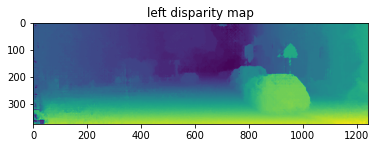

In [38]:
plt.imshow(disparity_map_left, cmap ='viridis')
plt.title('left disparity map')
plt.savefig('left_disp_map.png', dpi=300)

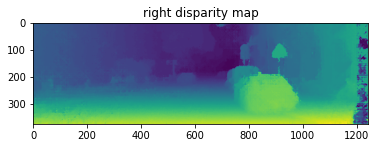

In [35]:
plt.imshow(disparity_map_right, cmap ='viridis')
plt.title('right disparity map')
plt.savefig('right_disp_map.png', dpi=300)


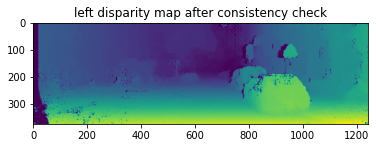

In [34]:
plt.imshow(consis_left_disparity_map, cmap ='viridis')
plt.title('left disparity map after consistency check')
plt.savefig('Consistency_check_left_disp_map.png', dpi=300)

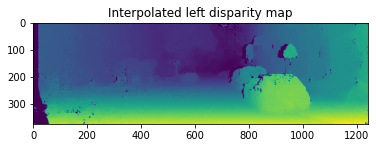

In [36]:
plt.imshow(final_left_disparity_map, cmap='viridis')
plt.title('Interpolated left disparity map')
plt.savefig('Interpolated_left_disp_map.png', dpi=300)